# Xây dựng dự án dự đoán mua bán hàng toàn diện bằng Logistic Regression

mục tiêu: 

- đưa ra các thông tin cần thiết cho bộ phận tiếp thị, marketing, chăm sóc khách hàng
- thuận tiện cho bộ phận xử lí dữ liệu, phân tích dữ liệu
- cá nhân hóa trải nghiệm của khách hàng

# Project Setup

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

# Data Collection and Preparation

giả sử đầu vào là lấy trực tiếp từ SQL, gồm các  thuộc tính: tuổi, thời gian truy cập, số trang xem, số lần mua trước, giá trị giỏ hàng, khách quay lại hay không(0,1), số ngày kể từ lần cuối vào trang web.

chúng ta sẽ tính xác xuất mua bằng cách: 

xác xuất mua = (0.02+0.001*(tuổi - 40)+ 0.05* thời gian truy cập + 0.03 * số trang xem + 0.1 * số lần mua trước đó + 0.001 * giá trị giỏ hàng + 0.2 * khách có quay lại không +-0.003 * số ngày kể từ lần cuối truy cập)

do đang thử nghiệm nên sẽ tạo ngẫu nhiên để test cho đến khi có được dữ liệu thật thì sẽ truyền vào

In [3]:
np.random.seed(42)

# Tạo dữ liệu khách hàng giả lập
n_samples = 1000  # Số lượng mẫu
age = np.random.normal(40, 15, n_samples)  
time_spent_on_site = np.random.exponential(5, n_samples)  
pages_visited = np.random.poisson(5, n_samples)  
previous_purchases = np.random.poisson(2, n_samples) 
cart_value = np.random.exponential(50, n_samples)  
is_returning_customer = np.random.binomial(1, 0.3, n_samples) 
days_since_last_visit = np.random.exponential(30, n_samples) 

# Tính xác suất mua hàng dựa trên các đặc trưng
purchase_prob = (0.02
                 + 0.001 * (age - 40)
                 + 0.05 * time_spent_on_site
                 + 0.03 * pages_visited
                 + 0.1 * previous_purchases
                 + 0.001 * cart_value
                 + 0.2 * is_returning_customer
                 - 0.003 * days_since_last_visit)

# Đảm bảo xác suất nằm trong khoảng từ 0 đến 0.9
purchase_prob = np.clip(purchase_prob, 0, 0.9)

# Tạo biến mục tiêu: mua hàng (1) hoặc không mua (0)
purchased = np.random.binomial(1, purchase_prob)

# Tạo DataFrame chứa dữ liệu khách hàng
customer_data = pd.DataFrame({
    'age': age,  # Tuổi
    'time_spent_on_site': time_spent_on_site, 
    'pages_visited': pages_visited,  
    'previous_purchases': previous_purchases, 
    'cart_value': cart_value,  
    'is_returning_customer': is_returning_customer, 
    'days_since_last_visit': days_since_last_visit, 
    'purchased': purchased  
})

print(customer_data.head())


         age  time_spent_on_site  pages_visited  previous_purchases  \
0  47.450712            0.916506              2                   2   
1  37.926035            0.552244              7                   2   
2  49.715328            5.058921              5                   3   
3  62.845448            6.128975              5                   4   
4  36.487699            0.160479              8                   2   

   cart_value  is_returning_customer  days_since_last_visit  purchased  
0   23.647242                      0              12.778776          1  
1  113.071609                      0               1.117658          1  
2   16.054145                      1               6.189104          1  
3   15.947042                      1              41.203766          1  
4   18.021405                      0              11.812129          1  


# Exploratory Data Analysis (EDA)

In [ ]:
# Thống kê mô tả cơ bản của dữ liệu
print(customer_data.describe())

# Kiểm tra giá trị bị thiếu trong dữ liệu
print("Giá trị bị thiếu trong từng cột:", customer_data.isnull().sum())
# Phân phối biến mục tiêu "purchased"
print("Phân phối giá trị của cột 'purchased' (đã mua hàng):")
print(customer_data['purchased'].value_counts(normalize=True))

               age  time_spent_on_site  pages_visited  previous_purchases  \
count  1000.000000         1000.000000    1000.000000         1000.000000   
mean     40.289981            5.039930       4.929000            2.032000   
std      14.688239            5.014943       2.096749            1.408886   
min      -8.619010            0.016117       0.000000            0.000000   
25%      30.286145            1.419773       3.000000            1.000000   
50%      40.379509            3.629656       5.000000            2.000000   
75%      49.719158            6.858421       6.000000            3.000000   
max      97.790972           37.208615      12.000000            8.000000   

        cart_value  is_returning_customer  days_since_last_visit    purchased  \
count  1000.000000            1000.000000            1000.000000  1000.000000   
mean     51.290432               0.289000              29.897319     0.617000   
std      53.438651               0.453525              29.82953

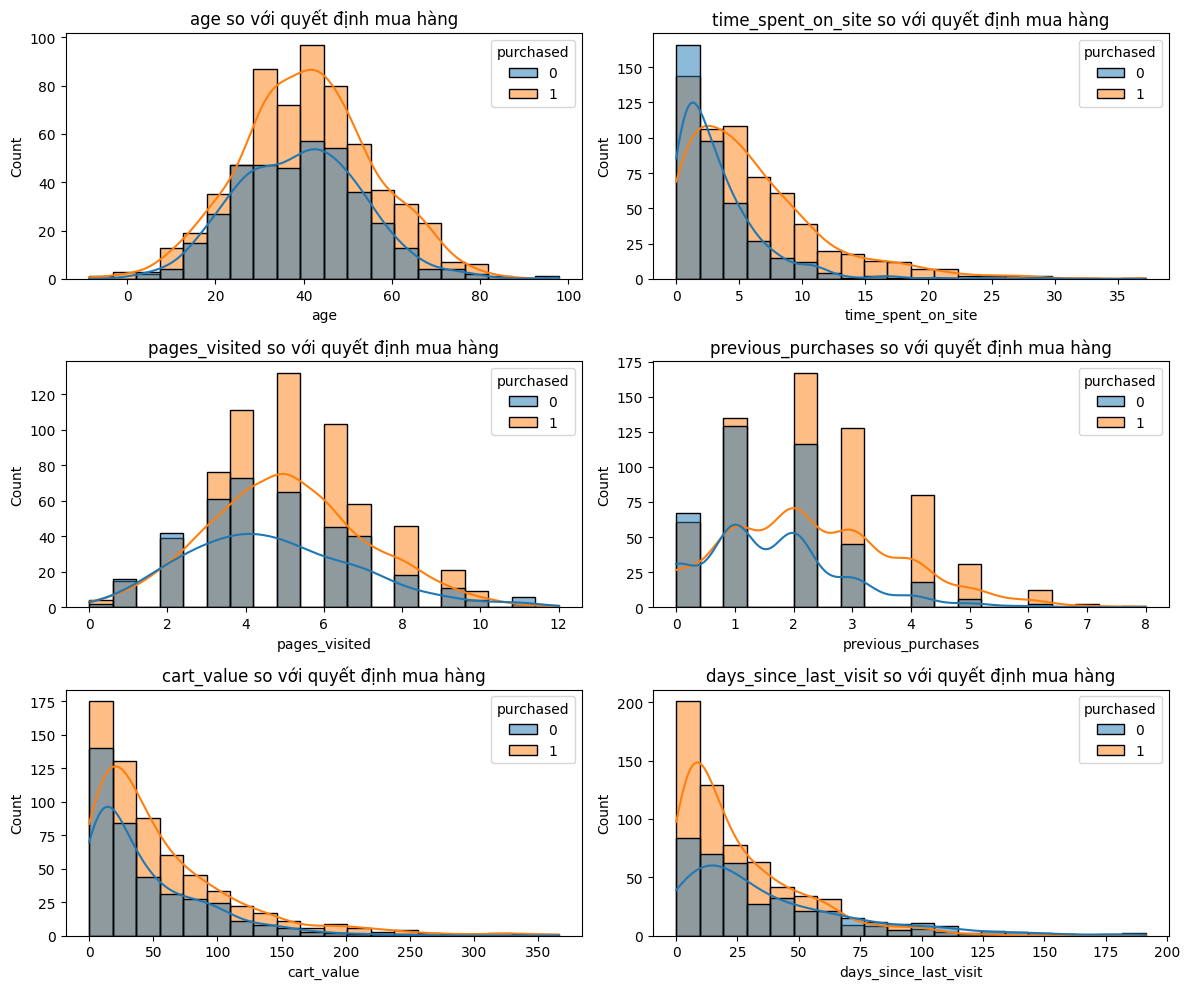

In [ ]:
# Trực quan hóa mối quan hệ giữa các biến
plt.figure(figsize=(12, 10))

# Phân phối của các đặc trưng số theo quyết định mua hàng
features = ['age', 'time_spent_on_site', 'pages_visited', 'previous_purchases',
            'cart_value', 'days_since_last_visit']

for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=customer_data, x=feature, hue='purchased', bins=20, kde=True)
    plt.title(f'{feature} so với quyết định mua hàng')
    plt.tight_layout()

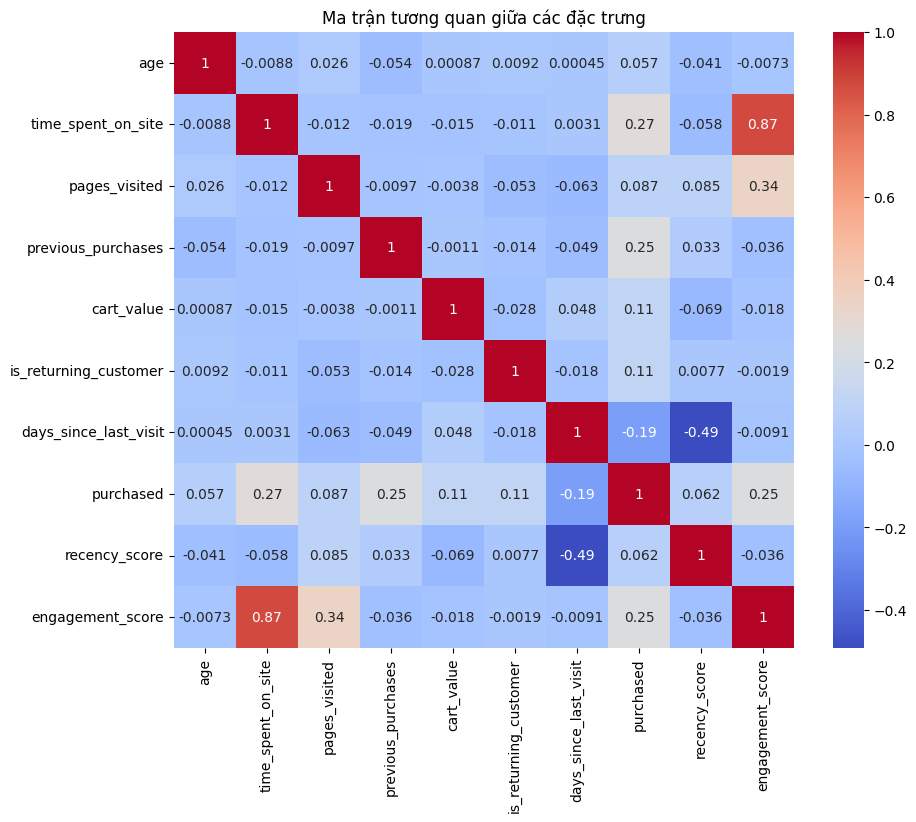

In [14]:
# Ma trận tương quan giữa các biến
plt.figure(figsize=(10, 8))
correlation = customer_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

# Feature Engineering and Preprocessing

In [6]:
# Tạo đặc trưng mới (Feature Engineering)
customer_data['recency_score'] = 1 / (1 + customer_data['days_since_last_visit']) 
customer_data['engagement_score'] = (customer_data['time_spent_on_site'] *
                                     customer_data['pages_visited']) / 10  

# Tạo ma trận đặc trưng X và biến mục tiêu y
X = customer_data.drop('purchased', axis=1)  # X là toàn bộ cột trừ cột 'purchased'
y = customer_data['purchased']  # y là cột mục tiêu: khách có mua hay không

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  
)

# In thông tin số lượng mẫu
print(f"Tập huấn luyện: {X_train.shape[0]} mẫu") 
print(f"Tập kiểm tra: {X_test.shape[0]} mẫu")  


Tập huấn luyện: 800 mẫu
Tập kiểm tra: 200 mẫu


# Building the Logistic Regression Model

In [7]:
# Tạo pipeline bao gồm tiền xử lý và mô hình
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Chuẩn hóa dữ liệu (đưa về cùng thang đo)
    ('classifier', LogisticRegression(random_state=42))  # Mô hình hồi quy logistic
])

# Huấn luyện mô hình trên tập huấn luyện
pipeline.fit(X_train, y_train)

# Trích xuất mô hình hồi quy logistic từ pipeline
model = pipeline.named_steps['classifier']

# Lấy hệ số (trọng số) của từng đặc trưng
coefficients = pd.DataFrame({
    'Feature': X_train.columns,  # Tên đặc trưng
    'Coefficient': model.coef_[0]  # Hệ số tương ứng với từng đặc trưng
})

# Sắp xếp theo giá trị tuyệt đối của hệ số (tầm quan trọng)
coefficients = coefficients.reindex(
    coefficients['Coefficient'].abs().sort_values(ascending=False).index
)

# In ra tầm quan trọng của các đặc trưng
print("Tầm quan trọng của các đặc trưng (Feature Importance):")
print(coefficients)


Tầm quan trọng của các đặc trưng (Feature Importance):
                 Feature  Coefficient
1     time_spent_on_site     1.319198
3     previous_purchases     0.706864
6  days_since_last_visit    -0.510824
8       engagement_score    -0.382294
5  is_returning_customer     0.358938
4             cart_value     0.311523
2          pages_visited     0.311483
0                    age     0.149158
7          recency_score    -0.085743


# Model Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        77
           1       0.73      0.82      0.77       123

    accuracy                           0.70       200
   macro avg       0.69      0.67      0.67       200
weighted avg       0.70      0.70      0.70       200



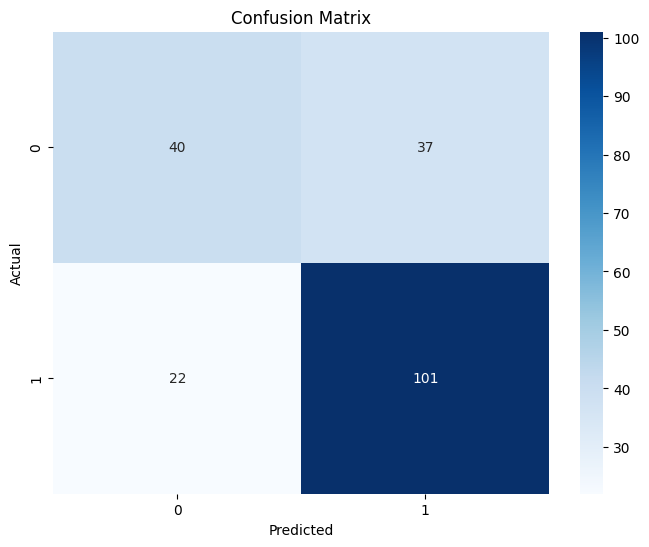

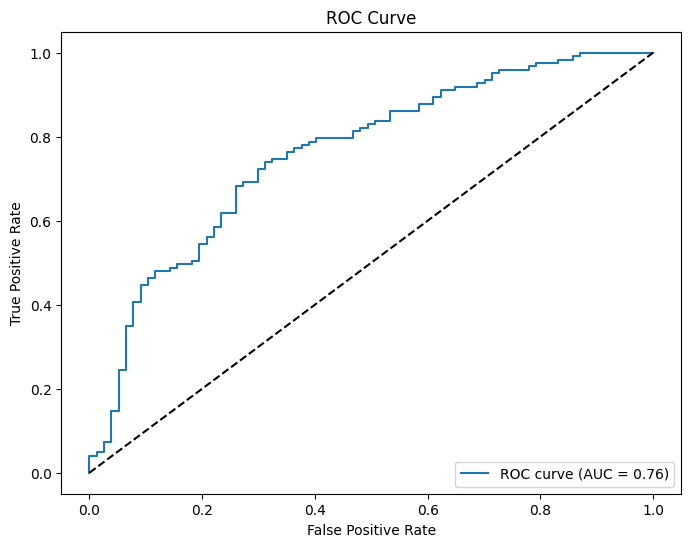

Cross-validation accuracy: 0.72 (+/- 0.02)


In [8]:
# Predictions
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

# Model Interpretation and Business Insights

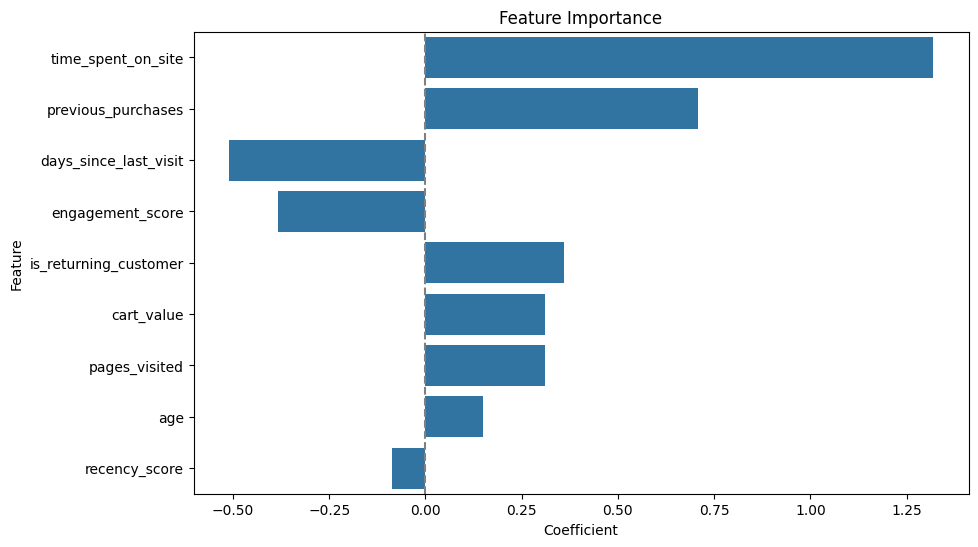

Odds Ratios (impact on purchase probability):
                 Feature  Odds Ratio  Coefficient
1     time_spent_on_site    3.740420     1.319198
3     previous_purchases    2.027622     0.706864
5  is_returning_customer    1.431808     0.358938
4             cart_value    1.365503     0.311523
2          pages_visited    1.365448     0.311483
0                    age    1.160856     0.149158
7          recency_score    0.917830    -0.085743
8       engagement_score    0.682295    -0.382294
6  days_since_last_visit    0.600001    -0.510824


In [ ]:
# Feature importance visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.axvline(x=0, color='gray', linestyle='--')
plt.show()

# Calculate odds ratios for better interpretation
odds_ratios = pd.DataFrame({
    'Feature': X_train.columns,
    'Odds Ratio': np.exp(model.coef_[0]),
    'Coefficient': model.coef_[0]
})

print("Odds Ratios (impact on purchase probability):")
print(odds_ratios.sort_values('Odds Ratio', ascending=False))

# Making Predictions on New Customers

Tham số:

new_customer_data (DataFrame): Các đặc trưng của khách hàng

pipeline: Pipeline mô hình đã được huấn luyện

Trả về:

DataFrame: Dữ liệu gốc kèm theo xác suất mua hàng

In [ ]:
# Hàm dự đoán xác suất mua hàng cho khách hàng mới
def predict_purchase_probability(new_customer_data, pipeline):
    # Tạo bản sao để tránh thay đổi dữ liệu gốc
    df = new_customer_data.copy()

    # Thêm các đặc trưng đã được tạo nếu chưa có sẵn
    if 'recency_score' not in df.columns:
        df['recency_score'] = 1 / (1 + df['days_since_last_visit'])
    if 'engagement_score' not in df.columns:
        df['engagement_score'] = (df['time_spent_on_site'] * df['pages_visited']) / 10

    # Lấy kết quả dự đoán xác suất
    purchase_prob = pipeline.predict_proba(df)[:, 1]

    # Thêm kết quả dự đoán vào DataFrame
    df['purchase_probability'] = purchase_prob  # Xác suất khách sẽ mua hàng
    df['likely_to_purchase'] = purchase_prob >= 0.5  # Dự đoán khách có khả năng mua hay không (True/False)

    return df

# Ví dụ sử dụng hàm với dữ liệu khách hàng mới
new_customers = pd.DataFrame({
    'age': [25, 45, 65],
    'time_spent_on_site': [2, 8, 1],
    'pages_visited': [3, 12, 2],
    'previous_purchases': [0, 5, 1],
    'cart_value': [20, 150, 30],
    'is_returning_customer': [0, 1, 1],
    'days_since_last_visit': [0, 5, 60]
})

# Tạo dự đoán
predictions = predict_purchase_probability(new_customers, pipeline)
print("Dự đoán mua hàng:")
print(predictions[['age', 'previous_purchases', 'purchase_probability', 'likely_to_purchase']])


Dự đoán mua hàng:
   age  previous_purchases  purchase_probability  likely_to_purchase
0   25                   0              0.150679               False
1   45                   5              0.989627                True
2   65                   1              0.318226               False


# Save the trained model:

In [12]:
import joblib
joblib.dump(pipeline, 'downloaded_model/purchase_prediction_model.pkl')

['downloaded_model/purchase_prediction_model.pkl']